In [23]:
import pandas as pd
from transformers import BertTokenizer


# Load datasets
prompts_test = pd.read_csv("../data/prompts_test.csv")
prompts_train = pd.read_csv("../data/prompts_train.csv")
summaries_test = pd.read_csv("../data/summaries_test.csv")
summaries_train = pd.read_csv("../data/summaries_train.csv")

# Drop student_id column from summaries_train and summaries_test
summaries_train = summaries_train.drop(columns=['student_id'])
summaries_test = summaries_test.drop(columns=['student_id'])
summaries_train = summaries_train[:50]

id_mapping = {id_val: idx for idx, id_val in enumerate(prompts_train['prompt_id'].unique())}

summaries_train['prompt_id'] = summaries_train['prompt_id'].replace(id_mapping)
summaries_test['prompt_id'] = summaries_test['prompt_id'].replace(id_mapping)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the 'text' column
texts = summaries_train['text'].tolist()
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

In [27]:
import pandas as pd
import torch
from transformers import BertForMaskedLM, BertTokenizer
from nltk.tokenize import sent_tokenize
import random
from tqdm.notebook import tqdm as tqdm_notebook
import nltk
nltk.download('punkt')

# Load model and tokenizer
model = BertForMaskedLM.from_pretrained('bert-base-uncased').eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_grammaticality_score(sentence):
    tokenized = tokenizer(sentence, return_tensors='pt')
    input_ids_tensor = tokenized['input_ids']

    total_score = 0
    for i in range(1, len(input_ids_tensor[0]) - 1):
        original_token = input_ids_tensor[0, i].item()
        input_ids_tensor[0, i] = tokenizer.mask_token_id
        with torch.no_grad():
            predictions = model(input_ids_tensor)
        predicted_prob = torch.nn.functional.softmax(predictions.logits[0, i], dim=-1)[original_token].item()
        total_score += predicted_prob
        input_ids_tensor[0, i] = original_token
        
    return total_score / (len(input_ids_tensor[0]) - 2)

def process_data_item(item):
    sentences = sent_tokenize(item)
    if len(sentences) > 5:
        sampled_sentences = random.sample(sentences, 5)
    else:
        sampled_sentences = sentences

    avg_score = sum([get_grammaticality_score(sentence) for sentence in sampled_sentences]) / len(sampled_sentences)
    return avg_score

# Create a tqdm progress bar for the DataFrame processing
grammaticality_scores = []
for text in tqdm_notebook(summaries_train['text'], desc="Processing rows"):
    score = process_data_item(text)
    grammaticality_scores.append(score)

summaries_train['grammaticality'] = grammaticality_scores

# Print the head of the updated DataFrame
print(summaries_train.head())



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sisun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing rows:   0%|          | 0/50 [00:00<?, ?it/s]

   prompt_id                                               text   content  \
0          2  The third wave was an experimentto see how peo...  0.205683   
1          3  They would rub it up with soda to make the sme... -0.548304   
2          1  In Egypt, there were many occupations and soci...  3.128928   
3          1  The highest class was Pharaohs these people we... -0.210614   
4          2  The Third Wave developed  rapidly because the ...  3.272894   

    wording  grammaticality  
0  0.380538        0.355910  
1  0.506755        0.560062  
2  4.231226        0.378759  
3 -0.471415        0.369086  
4  3.219757        0.470883  


In [28]:
correlation = summaries_train['wording'].corr(summaries_train['grammaticality'])
print(correlation)


-0.05577199482083919


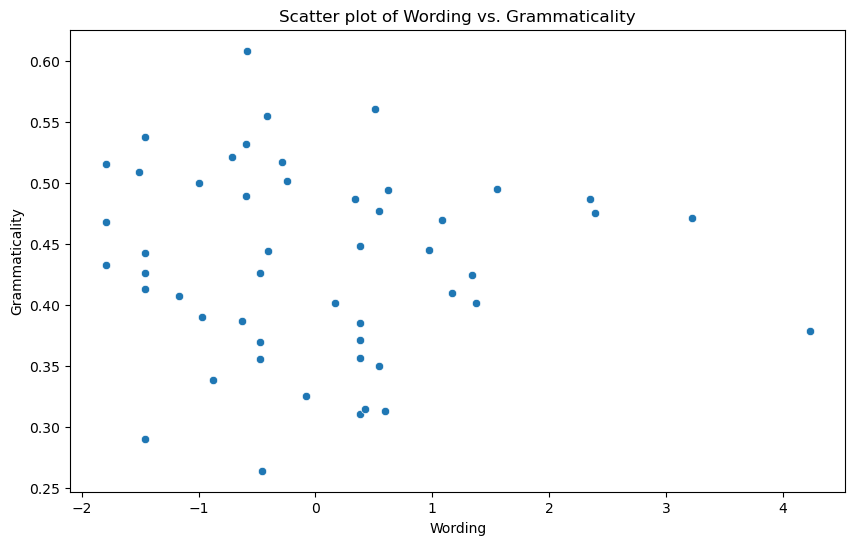

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=summaries_train, x='wording', y='grammaticality')

# Adding title and labels
plt.title('Scatter plot of Wording vs. Grammaticality')
plt.xlabel('Wording')
plt.ylabel('Grammaticality')

plt.show()
